# **Predicción de Ventas Basadas en el Stock Disponible y Otras Variables**

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_ofertas_relampago = pd.read_csv('/home/paulina/Documents/MercadoLibre/arquivos/ofertas_relampago.csv', encoding='latin1')

### Estrategias para Tratar los Valores Nulos

In [3]:
df_ofertas_relampago['SOLD_AMOUNT'].fillna(0, inplace=True)
df_ofertas_relampago['SOLD_QUANTITY'].fillna(0, inplace=True)

/tmp/ipykernel_163231/102810971.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ofertas_relampago['SOLD_AMOUNT'].fillna(0, inplace=True)
/tmp/ipykernel_163231/102810971.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [4]:
# Adicionamos nuevos valores para ver si el crecimiento de las hora durante el dia impacta
# Crear nuevas columnas a partir de las fechas
df_ofertas_relampago['OFFER_START_DTTM'] = pd.to_datetime(df_ofertas_relampago['OFFER_START_DTTM'])
df_ofertas_relampago['OFFER_FINISH_DTTM'] = pd.to_datetime(df_ofertas_relampago['OFFER_FINISH_DTTM'])
# Calcular la duración en horas
df_ofertas_relampago['OFFER_DURATION_HOURS'] = (df_ofertas_relampago['OFFER_FINISH_DTTM'] - df_ofertas_relampago['OFFER_START_DTTM']).dt.total_seconds() / 3600

In [5]:
df_ofertas_relampago['OFFER_START_DATE'] = pd.to_datetime(df_ofertas_relampago['OFFER_START_DATE'])
df_ofertas_relampago['OFFER_START_DAY'] = df_ofertas_relampago['OFFER_START_DATE'].dt.day
df_ofertas_relampago['OFFER_START_MONTH'] = df_ofertas_relampago['OFFER_START_DATE'].dt.month
df_ofertas_relampago['OFFER_START_WEEKDAY'] = df_ofertas_relampago['OFFER_START_DATE'].dt.weekday  # 0=Monday, 6=Sunday

### Definición de nuestras variables categorias:

*    **df_ofertas_relampago**:
        *    VERTICAL (Categoría del producto)
        *    SHIPPING_PAYMENT_TYPE (Tipo de pago de envío)
        *    OFFER_TYPE (Tipo de oferta): Esta categoria no la tomamos en cuenta ya que en nuestros dataset todos son del mismo tipo.
        *    DOMAIN_ID (Dominio del producto): Representa el tipo de producto específico dentro de una categoría

        

In [6]:
df_ofertas_relampago['VERTICAL'] = df_ofertas_relampago['VERTICAL'].astype('category')
df_ofertas_relampago['SHIPPING_PAYMENT_TYPE'] = df_ofertas_relampago['SHIPPING_PAYMENT_TYPE'].astype('category')
df_ofertas_relampago['DOMAIN_ID'] = df_ofertas_relampago['DOMAIN_ID'].astype('category')

In [7]:
# Definir las columnas categóricas para CatBoost
cat_features = ['VERTICAL', 'SHIPPING_PAYMENT_TYPE', 'DOMAIN_ID']

###  Columnas Numéricas

*    **df_ofertas_relampago**:
        *    INVOLVED_STOCK (Stock involucrado)
        *    REMAINING_STOCK_AFTER_END (Stock restante)
        *    SOLD_AMOUNT (Monto vendido)
        *    OFFER_DURATION_HOURS (Duración de la oferta en horas, derivada)
        *    STOCK_DEPLETION_RATE (Tasa de agotamiento de stock, derivada)        *    

In [8]:
# Definir as features (atributos de entrada)
features = [
    'VERTICAL', 'SHIPPING_PAYMENT_TYPE', 'DOMAIN_ID',
    'INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'OFFER_DURATION_HOURS',
    'OFFER_START_DAY', 'OFFER_START_MONTH', 'OFFER_START_WEEKDAY'
]

In [9]:
df_ofertas_relampago = df_ofertas_relampago[[
    'VERTICAL', 'SHIPPING_PAYMENT_TYPE', 'DOMAIN_ID',
    'INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'OFFER_DURATION_HOURS',
    'OFFER_START_DAY', 'OFFER_START_MONTH', 'OFFER_START_WEEKDAY', 'SOLD_QUANTITY'
]]
df_ofertas_relampago.dtypes

VERTICAL                     category
SHIPPING_PAYMENT_TYPE        category
DOMAIN_ID                    category
INVOLVED_STOCK                  int64
REMAINING_STOCK_AFTER_END       int64
SOLD_AMOUNT                   float64
OFFER_DURATION_HOURS          float64
OFFER_START_DAY                 int32
OFFER_START_MONTH               int32
OFFER_START_WEEKDAY             int32
SOLD_QUANTITY                 float64
dtype: object

*    SOLD_QUANTITY (Cantidad vendida, que será nuestra variable objetivo)

In [10]:
# Definir la variable objetivo
target = 'SOLD_QUANTITY'

In [11]:
# Separar los datos en características (X) y variable objetivo (y)
X = df_ofertas_relampago[features]
y = df_ofertas_relampago[target]

print(X.shape)
print(y.shape)

# Verificar la distribución de la variable objetivo
unique, counts = np.unique(y, return_counts=True)
result = np.column_stack((unique, counts))
#print(result)

(48746, 10)
(48746,)


In [12]:
# Dividir entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Aplicar el modelo CatBoostRegressor
Estoy optando de aplicar este modelo por que es basado en árboles de decisión, específicamente diseñado para manejar problemas de regresión y datos categoricos. Puede modelar de manera eficiente la relación entre el stock disponible, las promociones y las ventas, proporcionando predicciones más precisas.

In [13]:
# Definir el modelo CatBoostRegressor
catboost_model = CatBoostRegressor(cat_features=cat_features, verbose=0)

**GridSearchCV:** Utilizamos GridSearchCV para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo CatBoostRegressor. Evaluamos combinaciones de:

In [70]:
catboost_param_grid = {
    'iterations': [500, 1000, 1500], 
    'depth': [3, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'l2_leaf_reg': [0.5, 1, 3], # Probaremos con un rango amplio para la penalizacion, pues queremos evitar el sobreajustarse
    #'border_count': [32, 64, 128],
    #'bagging_temperature': [0.1, 0.5, 1, 2], 
    #'random_strength': [1, 2, 5],
    #'one_hot_max_size': [2, 5], 
    #'scale_pos_weight': [0.5, 1, 2] 
}

In [71]:
catboost_grid = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
catboost_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x78b9afa3de90>,
             n_jobs=-1,
             param_grid={'depth': [3, 6, 8, 10],
                         'iterations': [500, 1000, 1500],
                         'l2_leaf_reg': [0.5, 1, 3],
                         'learning_rate': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [72]:
# Obtener los mejores parámetros
best_params_cat = catboost_grid.best_params_
print("Mejores parámetros encontrados para CatBoostRegressor:", best_params_cat)

Mejores parámetros encontrados para CatBoostRegressor: {'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Algo bueno del CatBoost es que te permite trabajar con variables categoricas, para explorar con otros modelos adicionaremos una pequeña transformación en nuestras variables categoricas para que se menajene de forma numerica.

In [30]:
# Preprocesar las variables categóricas usando OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['VERTICAL', 'SHIPPING_PAYMENT_TYPE', 'DOMAIN_ID']),
    ], remainder='passthrough')

### Aplicar el modelo Random Forest Regressor

Es robusto y maneja bien las interacciones no lineales entre las variables, de igual forma basado en árboles de decisión que ayuda a reducir el riesgo de sobreajuste y mejora la precisión general.

In [31]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


De igual forma establecemos el rango de busqueda de hiperparametros utilizando GridSearchCV:

In [32]:
rf_param_grid = {
    'model__n_estimators': [500, 1000, 1500],
    'model__max_depth': [4, 6, 8],
    'model__min_samples_split': [2, 5, 10]
}

In [33]:
# Configurar GridSearchCV para Random Forest
rf_grid = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['VERTICAL',
                                                                          'SHIPPING_PAYMENT_TYPE',
                                                                          'DOMAIN_ID'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [4, 6, 8],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [500, 1000, 1500]},
             scoring='neg_mean_squared_error')

In [34]:
# Obtener los mejores parámetros
best_params_rf = rf_grid.best_params_
print("Mejores parámetros encontrados para Random Forest Regressor:", best_params_rf)

Mejores parámetros encontrados para Random Forest Regressor: {'model__max_depth': 8, 'model__min_samples_split': 2, 'model__n_estimators': 500}


### Aplicar el modelo XGBoost Regressor

Exploraremos con un modelo más para fines de cexploración y comparación, para ilustrar que modelo se ajusta mejor para obtener una alta precisión en relación a los tipos de datos que tenemos, el modelo XGBoost Regressor también ofrece control avanzado sobre la regularización, lo que puede ayudar a mejorar la precisión y prevenir el sobreajuste.

In [35]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

In [36]:
# Definir el espacio de búsqueda de hiperparámetros para XGBoost
xgb_param_grid = {
    'model__n_estimators': [500, 1000, 1500],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__max_depth': [4, 6, 8],
    'model__reg_lambda': [0.1, 1, 3]  # Regularización L2
}

In [ ]:

xgb_param_grid = {
    'model__n_estimators': [100, 200, 500, 800, 1000],
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 6, 8, 10],
    'model__min_child_weight': [1, 3, 5, 7], # Regularización adicional para evitar sobreajuste
    'model__gamma': [0, 0.1, 0.3, 0.5, 1], 
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'model__reg_alpha': [0, 0.01, 0.1, 1],  # Regularización L1
    'model__reg_lambda': [0, 0.01, 0.1, 1]  # Regularización L2
}

In [37]:
# Configurar GridSearchCV para XGBoost
xgb_grid = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['VERTICAL',
                                                                          'SHIPPING_PAYMENT_TYPE',
                                                                          'DOMAIN_ID'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     de...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1],
                         'model__max_depth': [4, 6, 8],
                         'model__n_estimators': [500, 1000, 1500],
                         'model__reg_lambda': [0.1, 1, 3]},
             scoring='neg_mean_squared_error')

In [38]:
# Obtener los mejores parámetros
best_params_xgb = xgb_grid.best_params_
print("Mejores parámetros encontrados para XGBoost:", best_params_xgb)

Mejores parámetros encontrados para Random Forest XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__reg_lambda': 1}


Hasta este punto logramos entrenar nuestros modelos, encontramos los mejores hiperparametros para cada uno de ellos, con las cuales funciona mejor.

In [73]:
# Obtenemos el mejor modelo de cada GridSearchCV
best_catboost = catboost_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

In [74]:
# Realizamos predicciones con el mejor modelo de cada uno
y_test_pred_cb = best_catboost.predict(X_test)
y_test_pred_rf = best_rf.predict(X_test)
y_test_pred_xgb = best_xgb.predict(X_test)

In [75]:
# Métricas de rendimiento para cada modelo
def calculate_metrics(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    accuracy = accuracy_score(y_true, y_pred_rounded)
    recall = recall_score(y_true, y_pred_rounded, average='weighted')
    precision = precision_score(y_true, y_pred_rounded, average='weighted')
    f1 = f1_score(y_true, y_pred_rounded, average='weighted')
    return rmse, accuracy, recall, precision, f1

metrics_cb = calculate_metrics(y_test, y_test_pred_cb)
metrics_rf = calculate_metrics(y_test, y_test_pred_rf)
metrics_xgb = calculate_metrics(y_test, y_test_pred_xgb)

# DataFrame con los resultados
comparison_df = pd.DataFrame({
    'Model': ['CatBoost', 'Random Forest', 'XGBoost'],
    'RMSE': [metrics_cb[0], metrics_rf[0], metrics_xgb[0]],
    'Accuracy': [metrics_cb[1], metrics_rf[1], metrics_xgb[1]],
    'Recall': [metrics_cb[2], metrics_rf[2], metrics_xgb[2]],
    'Precision': [metrics_cb[3], metrics_rf[3], metrics_xgb[3]],
    'F1_Score': [metrics_cb[4], metrics_rf[4], metrics_xgb[4]]
})
comparison_df

/home/paulina/anaconda3/envs/Data_Science/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paulina/anaconda3/envs/Data_Science/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paulina/anaconda3/envs/Data_Science/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paulina/anaconda3/en

,Model,RMSE,Accuracy,Recall,Precision,F1_Score
0,CatBoost,8.980647,0.837333,0.837333,0.846139,0.841144
1,Random Forest,8.525068,0.721128,0.721128,0.738190,0.726372
2,XGBoost,12.370749,0.771179,0.771179,0.789158,0.778178


El valor RMSE indica la magnitud promedio de los errores de predicción, donde un menor RMSE indica un mejor rendimiento: Un modelo RMSE 0 indica un modelo altamente preciso. En nuestro caso 8.52 en Random Forest, podría ser considerado óptimo, este siendo comparado con otros dos modelos, sin embargo seria bueno comparar con otros modelos para ver si conseguimos un valor mas bajo u explorar un mayor margen de busqueda de hiperparametros, que eso equivaldria a mayor recurso computacional.

In [56]:
metrics_df = pd.DataFrame(columns=['Modelo', 'Datos', 'Accuracy', 'Recall', 'Precision', 'F1_Score'])

models = [
    ('CatBoost', best_catboost),
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb)
]

for model_name, model in models:
    # Predicciones en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_pred_class = np.round(y_train_pred)  # Redondear para obtener la clase si es necesario

    # Calcular métricas en el conjunto de entrenamiento
    accuracy_train = accuracy_score(y_train, y_train_pred_class)
    recall_train = recall_score(y_train, y_train_pred_class, average='weighted')
    precision_train = precision_score(y_train, y_train_pred_class, average='weighted')
    f1_train = f1_score(y_train, y_train_pred_class, average='weighted')

    # Guardar las métricas en el DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({'Modelo': [model_name], 'Datos': [f'Train'], 
                                                      'Accuracy': [accuracy_train], 
                                                      'Recall': [recall_train], 
                                                      'Precision': [precision_train], 
                                                      'F1_Score': [f1_train]})], ignore_index=True)

    # Predicciones en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    y_test_pred_class = np.round(y_test_pred)  # Redondear para obtener la clase si es necesario

    # Calcular métricas en el conjunto de prueba
    accuracy_test = accuracy_score(y_test, y_test_pred_class)
    recall_test = recall_score(y_test, y_test_pred_class, average='weighted')
    precision_test = precision_score(y_test, y_test_pred_class, average='weighted')
    f1_test = f1_score(y_test, y_test_pred_class, average='weighted')

    metrics_df = pd.concat([metrics_df, pd.DataFrame({'Modelo': [model_name], 'Datos': [f'Test'], 
                                                      'Accuracy': [accuracy_test], 
                                                      'Recall': [recall_test], 
                                                      'Precision': [precision_test], 
                                                      'F1_Score': [f1_test]})], ignore_index=True)

metrics_df

/home/paulina/anaconda3/envs/Data_Science/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paulina/anaconda3/envs/Data_Science/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_163231/3950506989.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df =

,Modelo,Datos,Accuracy,Recall,Precision,F1_Score
0,CatBoost,Train,0.850703,0.850703,0.857440,0.853537
1,CatBoost,Test,0.837333,0.837333,0.846139,0.841144
2,Random Forest,Train,0.725433,0.725433,0.744022,0.731242
3,Random Forest,Test,0.721128,0.721128,0.738190,0.726372
4,XGBoost,Train,0.779618,0.779618,0.796676,0.786263
5,XGBoost,Test,0.771179,0.771179,0.789158,0.778178


Nuestros resultados son excelentes, obtuvimos un accuracy entre 72% y 85%, en este caso CatBoost supera tanto en acurracy como en Precision. Los valores Recall, Precision, F1_Score son razonablemente altos, lo que indica que el modelo tiene un buen balance entre precisión y capacidad de generalización.

### Analizar las Predicciones:

In [58]:
comparison_df = pd.DataFrame({
    'Real': y_test,
    'CatBoost Predicción': np.round(best_catboost.predict(X_test)),
    'Random Forest Predicción': np.round(best_rf.predict(X_test)),
    'XGBoost Predicción': np.round(best_xgb.predict(X_test))
})
comparison_df.head(20)

,Real,CatBoost Predicción,Random Forest Predicción,XGBoost Predicción
14829,0.0,-0.0,0.0,0.0
10115,1.0,1.0,2.0,1.0
36315,0.0,0.0,0.0,-0.0
25736,0.0,0.0,0.0,0.0
6211,7.0,6.0,5.0,6.0
19434,6.0,6.0,6.0,6.0
34284,0.0,-0.0,0.0,-0.0
18508,0.0,-0.0,0.0,-0.0
45619,0.0,0.0,0.0,0.0
18810,0.0,-0.0,0.0,0.0


Las predicciones realizadas por el mejor modelo se encuentran bastante cercanas a los valores reales, como lo reflejan las métricas en el dataframe.

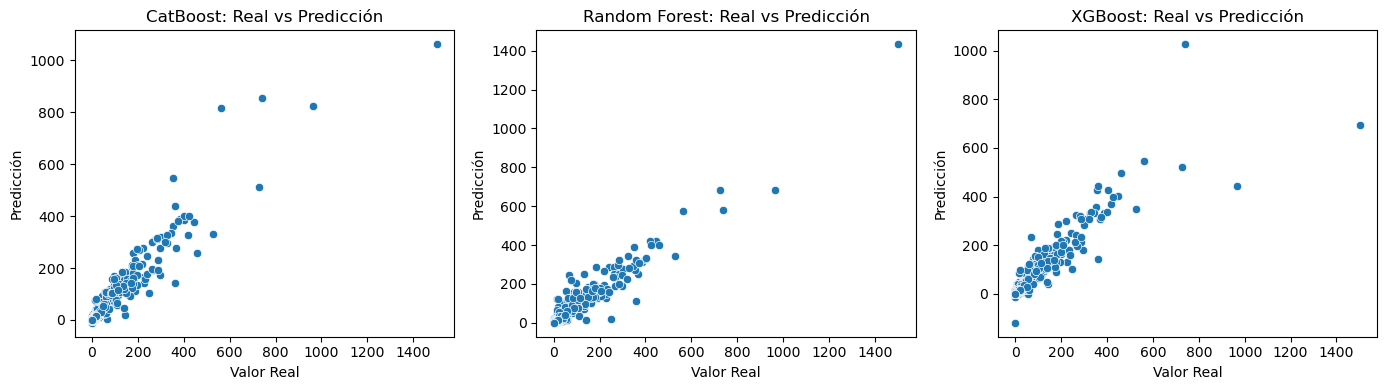

In [62]:
# Gráfico de dispersión para ver las predicciones vs valores reales
plt.figure(figsize=(14, 4))

# CatBoost
plt.subplot(1, 3, 1)
sns.scatterplot(x=comparison_df['Real'], y=comparison_df['CatBoost Predicción'])
plt.title('CatBoost: Real vs Predicción')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')

# Random Forest
plt.subplot(1, 3, 2)
sns.scatterplot(x=comparison_df['Real'], y=comparison_df['Random Forest Predicción'])
plt.title('Random Forest: Real vs Predicción')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')

# XGBoost
plt.subplot(1, 3, 3)
sns.scatterplot(x=comparison_df['Real'], y=comparison_df['XGBoost Predicción'])
plt.title('XGBoost: Real vs Predicción')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')

plt.tight_layout()
plt.show()

Podemos observar mediante este grafico de dispersión como se esta comportando nuestros datos en relación al valor real y lo predecido. El CatBoost, se observa que la mayoría de los puntos están cerca de la diagonal, sin embargo, hay algunos que están alejados de esta diagonal, lo que sugiere que hay algunos errores significativos en ciertas predicciones. En XGBoost los datos se comportan de igual forma cerca de la diagonal pero parece que hay una mayor dispersión en los valores más altos, quizas puede indicar posibles problemas de ajuste en esos casos. En Random Forest  al igual que los otros modelos, hay algunos puntos alejados de la diagonal, aunque en menor cantidad.

In [65]:
# Agregar una columna de error absoluto para cada modelo
comparison_df['CatBoost Error'] = abs(comparison_df['Real'] - comparison_df['CatBoost Predicción'])
comparison_df['Random Forest Error'] = abs(comparison_df['Real'] - comparison_df['Random Forest Predicción'])
comparison_df['XGBoost Error'] = abs(comparison_df['Real'] - comparison_df['XGBoost Predicción'])

# Ordenar el DataFrame por el error más grande
comparison_df = comparison_df.sort_values(by=['CatBoost Error', 'Random Forest Error', 'XGBoost Error'], ascending=False)

# Mostrar las primeras filas con mayor error
comparison_df.head(10)

,Real,CatBoost Predicción,Random Forest Predicción,XGBoost Predicción,CatBoost Error,Random Forest Error,XGBoost Error
11449,1503.0,1062.0,1433.0,695.0,441.0,70.0,808.0
8344,562.0,818.0,576.0,548.0,256.0,14.0,14.0
22254,360.0,144.0,112.0,144.0,216.0,248.0,216.0
43829,726.0,512.0,684.0,523.0,214.0,42.0,203.0
23981,459.0,256.0,398.0,495.0,203.0,61.0,36.0
8358,527.0,332.0,344.0,349.0,195.0,183.0,178.0
35641,354.0,548.0,274.0,426.0,194.0,80.0,72.0
11839,249.0,103.0,22.0,103.0,146.0,227.0,146.0
11380,965.0,824.0,685.0,444.0,141.0,280.0,521.0
9986,143.0,18.0,16.0,39.0,125.0,127.0,104.0


Aqui podemos ver los valores que mayores errores tiene nuestro modelo al poder predecirlos. Quizar explorar más profundos por que en valores altos nuestro modelo tiene deficiencia, seria bueno.

**Conclusion:**

Hemos desarrollado un modelo que predice con precisión la cantidad de ventas basadas en el stock disponible y otras variables. Esto permite ajustar el inventario y las estrategias de marketing para optimizar las ventas.

Ademas de ello, a partir de las predicciones de ventas, se puede calcular la rentabilidad esperada para cualquier nivel de stock, permitiendo tomar decisiones estratégicas sobre cómo ajustar el inventario y las ofertas para maximizar el margen de ganancia.

**Recomendaciones:**
*   Calculo Directo de Rentabilidad: Implementar directamente en el código el cálculo de rentabilidad basada en las predicciones de ventas y costos.
*   Ajuste de Precios y Promociones: Usar las predicciones para ajustar precios y promociones con el objetivo de maximizar la rentabilidad.
*   Análisis de Sensibilidad: Explorar cómo cambios en las variables clave, como el stock disponible o los costos, afectan la rentabilidad para optimizar las decisiones de negocio.
*   Predicción de la Demanda y Agotamiento del Stock
*   Segmentación de Mercado y Predicción por Segmento